In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import itertools
import plotly.graph_objects as go

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import KNNImputer


In [47]:
df = pd.read_csv(r"C:\Users\pc\Desktop\diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [48]:
def check_df(dataframe, head=5):
    print("-------------------- Shape --------------------")
    print(dataframe.shape)
    print("-------------------- Types --------------------")
    print(dataframe.dtypes)
    print("-------------------- Head --------------------")
    print(dataframe.head(head))
    print("-------------------- Tail --------------------")
    print(dataframe.tail(head))
    print("-------------------- NA --------------------")
    print(dataframe.isnull().sum())
    print("-------------------- Quantiles --------------------")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

-------------------- Shape --------------------
(768, 9)
-------------------- Types --------------------
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
-------------------- Head --------------------
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50 

In [49]:
# Select numeric columns
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()

# Select categorical columns
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric Columns:", numeric_columns)
print("Categorical Columns:", categorical_columns)

Numeric Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
Categorical Columns: []


0    500
1    268
Name: Outcome, dtype: int64


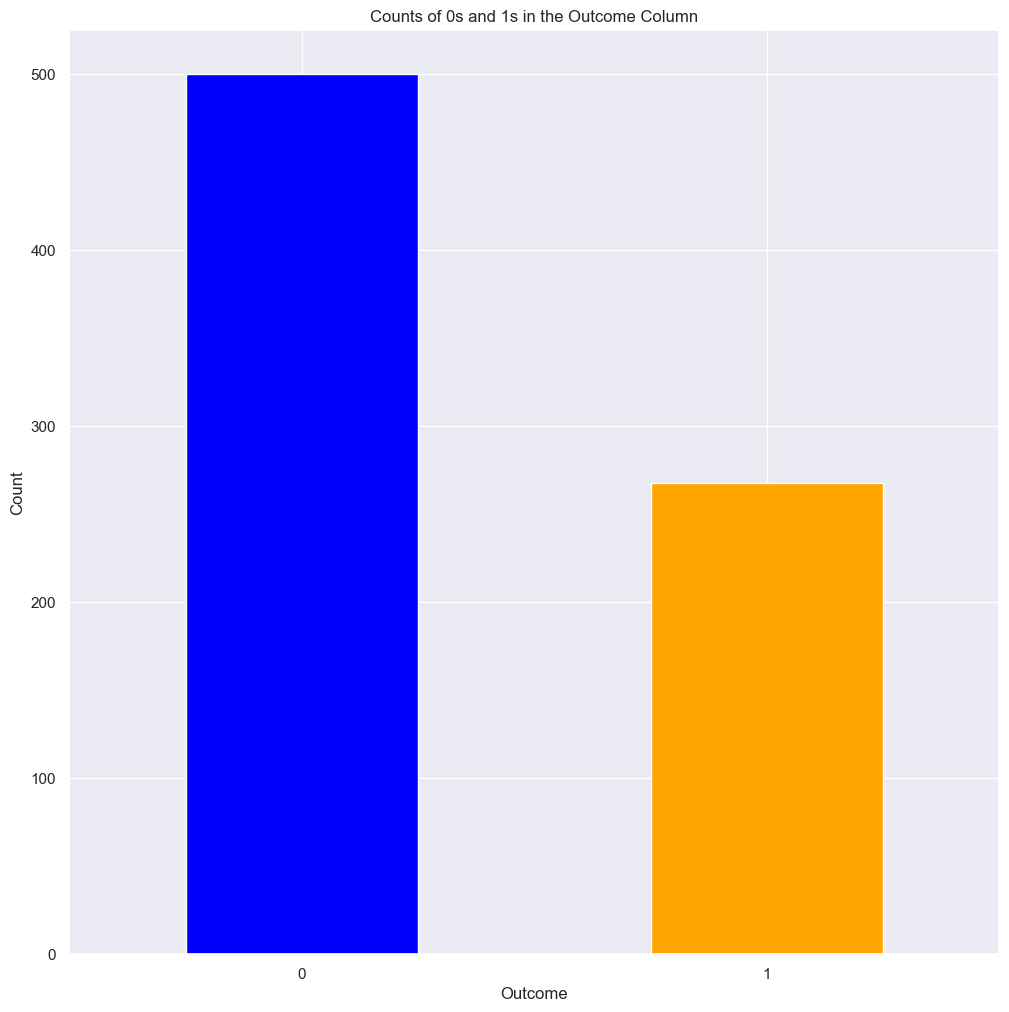

In [50]:
outcome_counts = df['Outcome'].value_counts()
print(outcome_counts)

# Plot the counts
outcome_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Counts of 0s and 1s in the Outcome Column')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


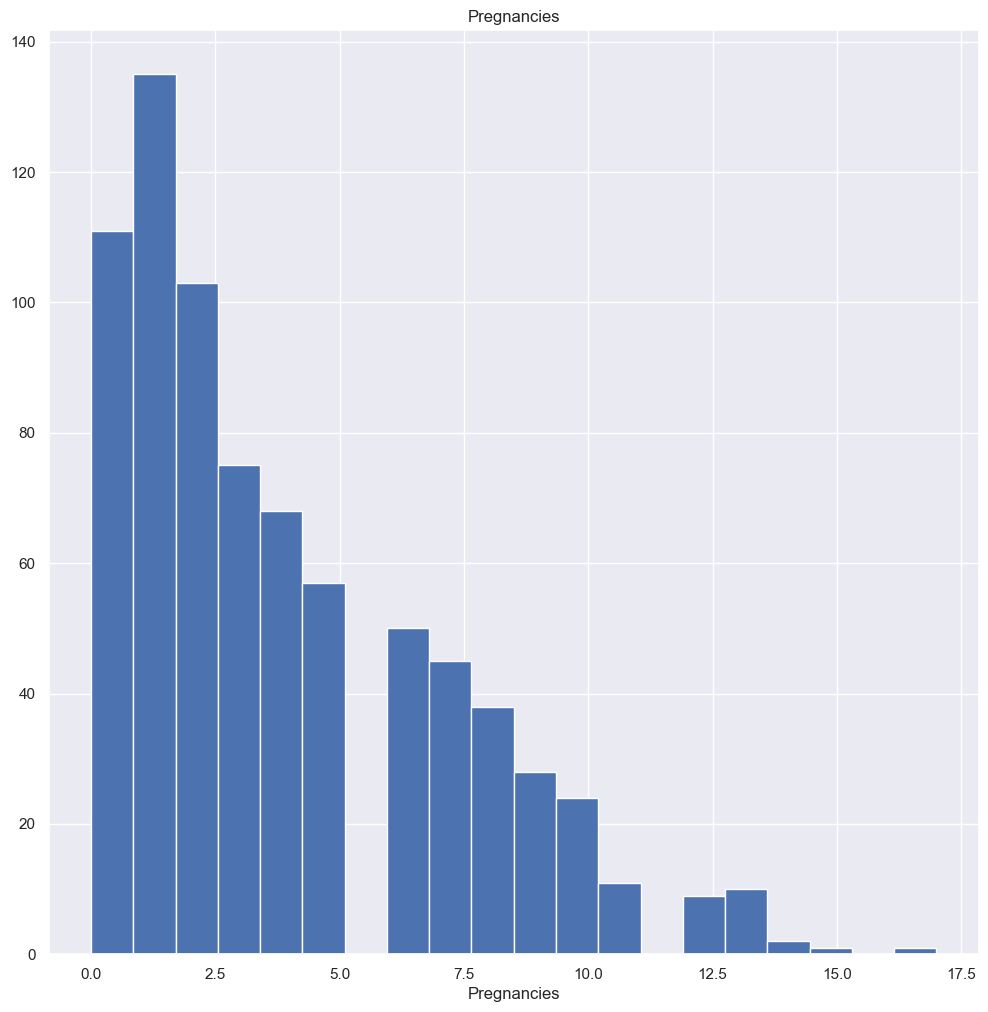

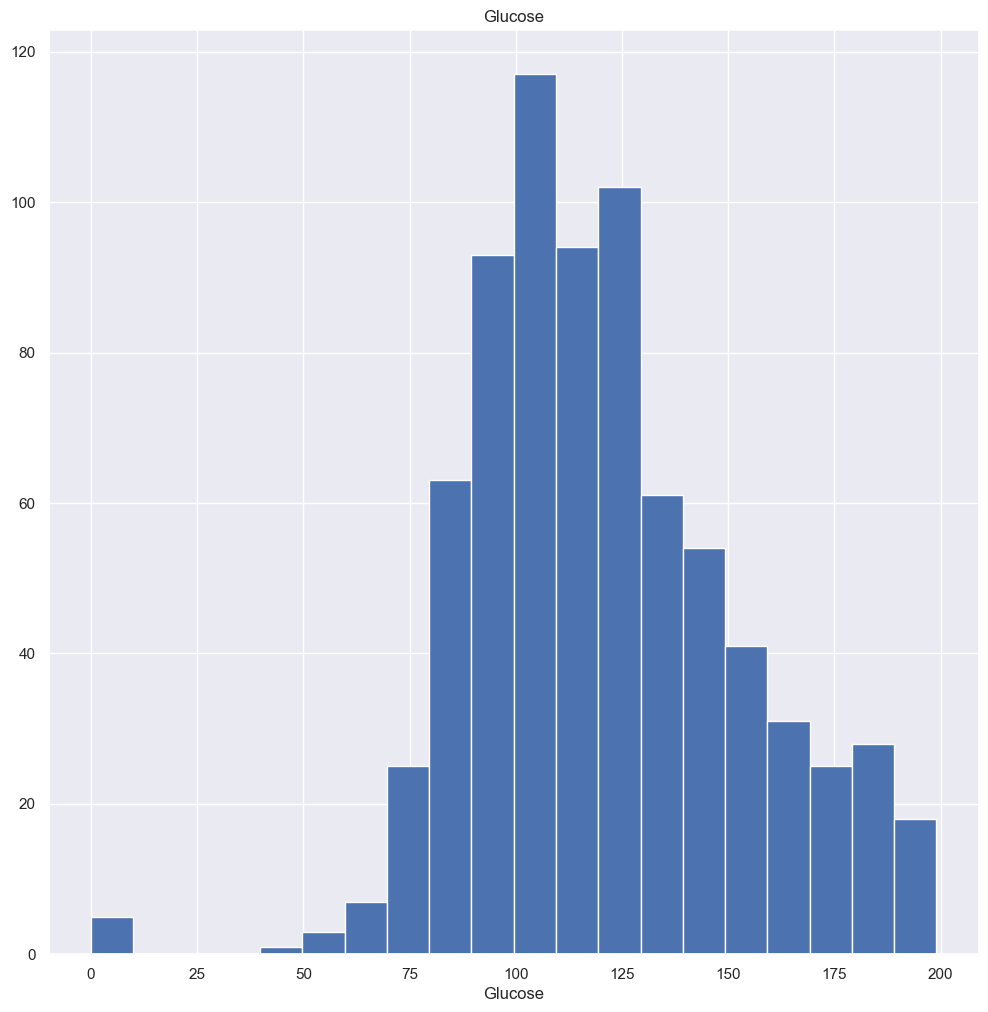

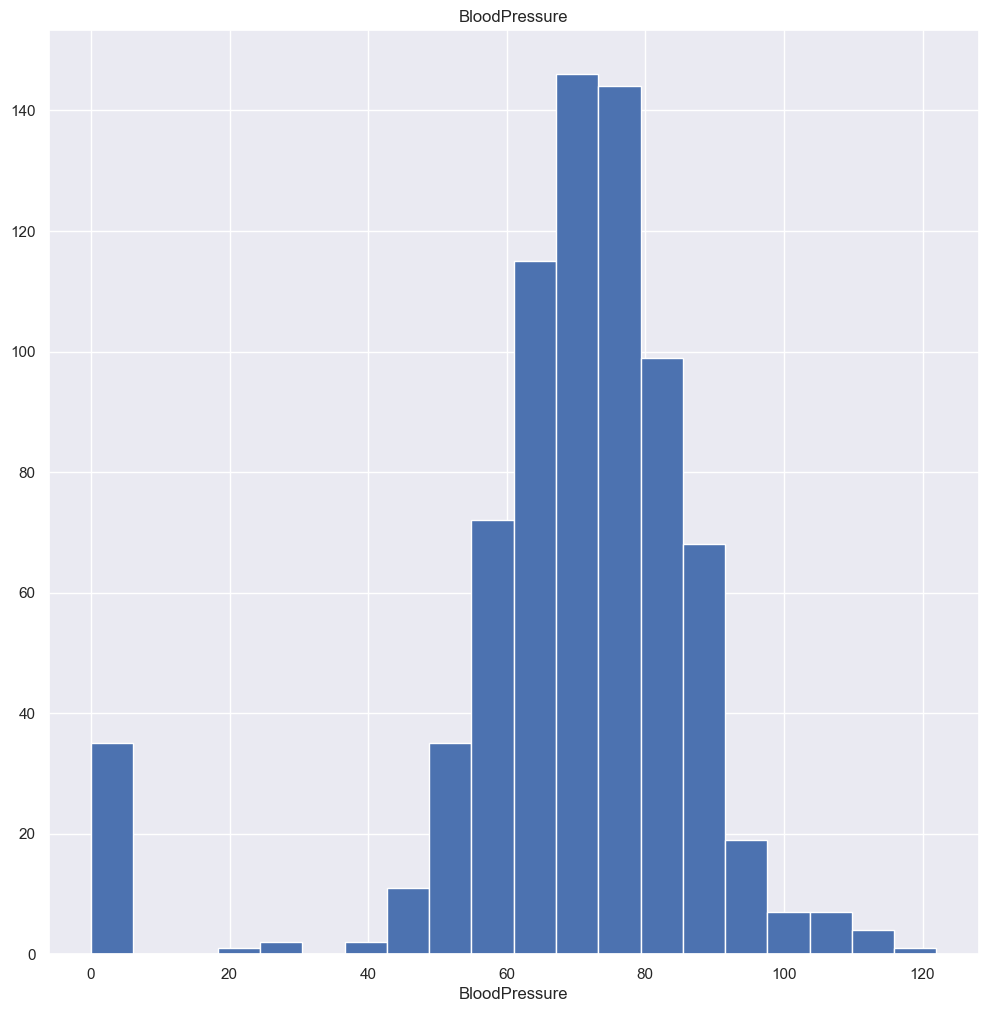

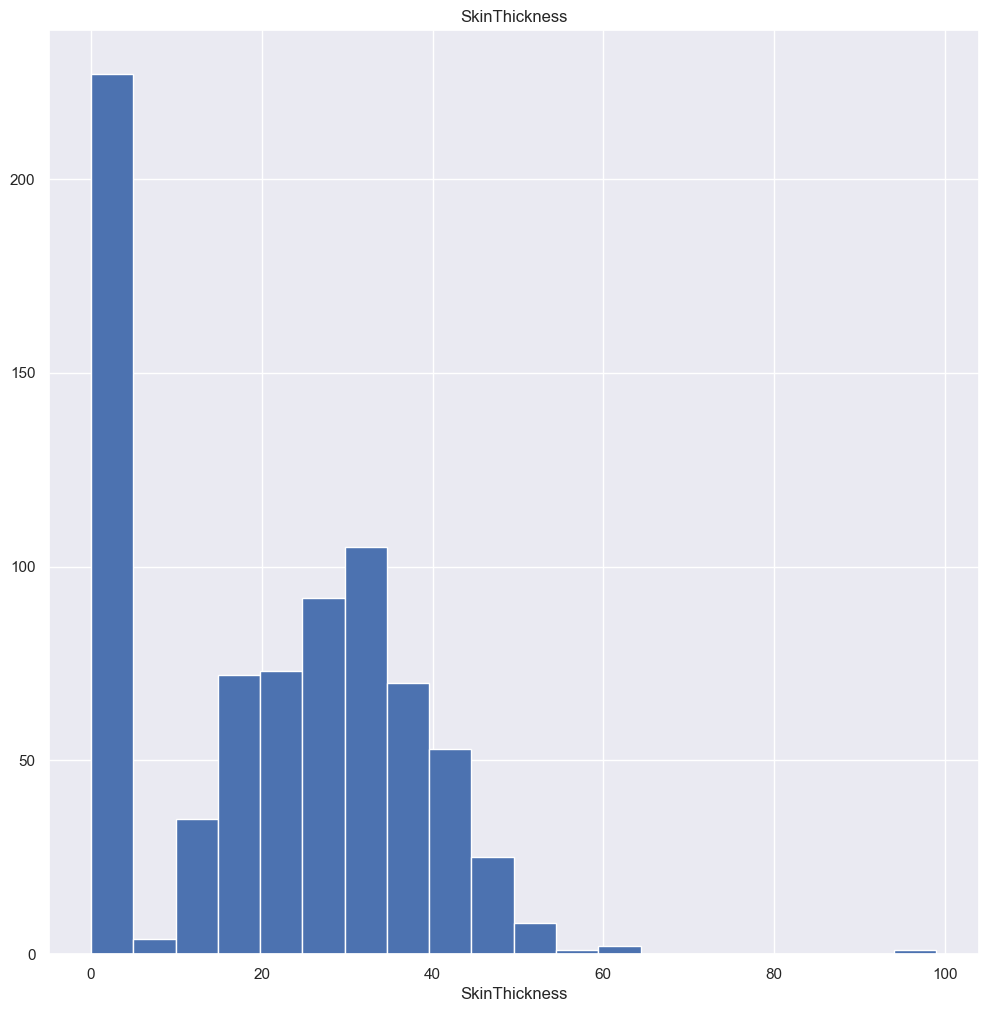

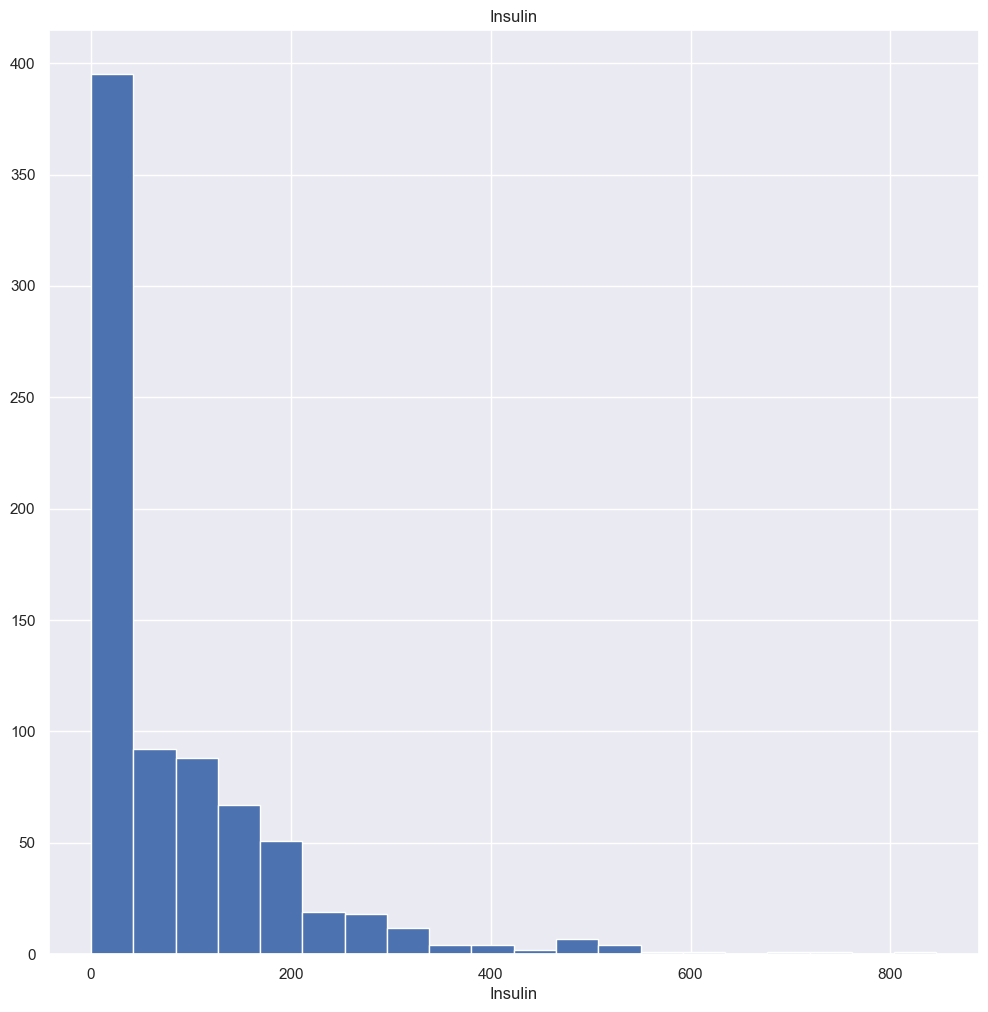

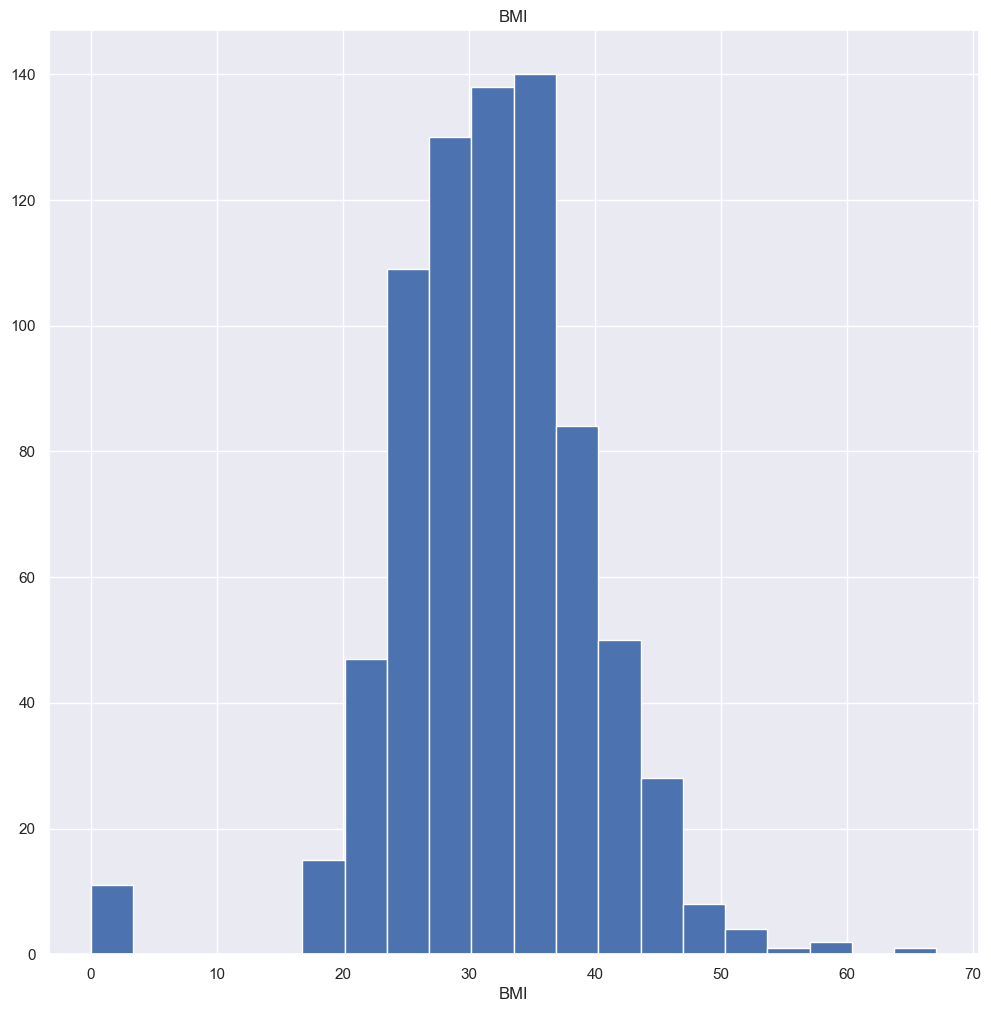

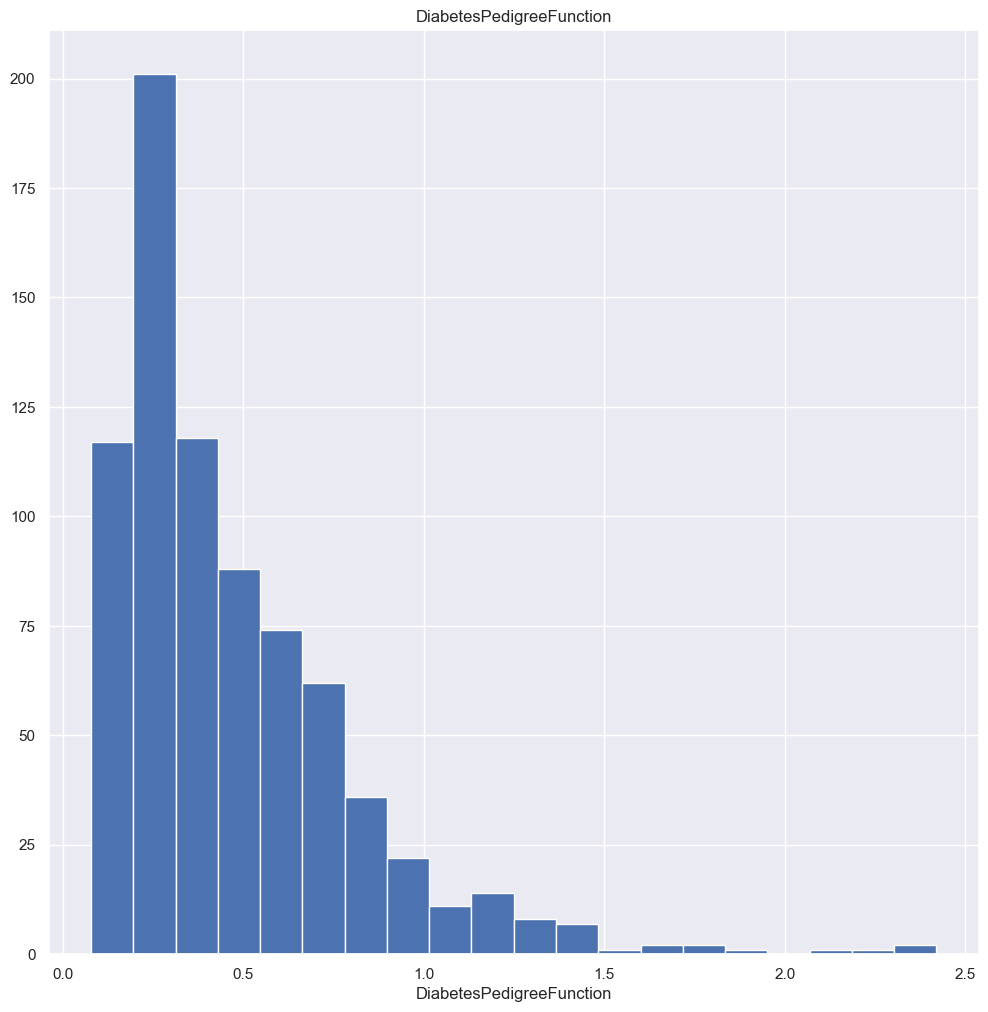

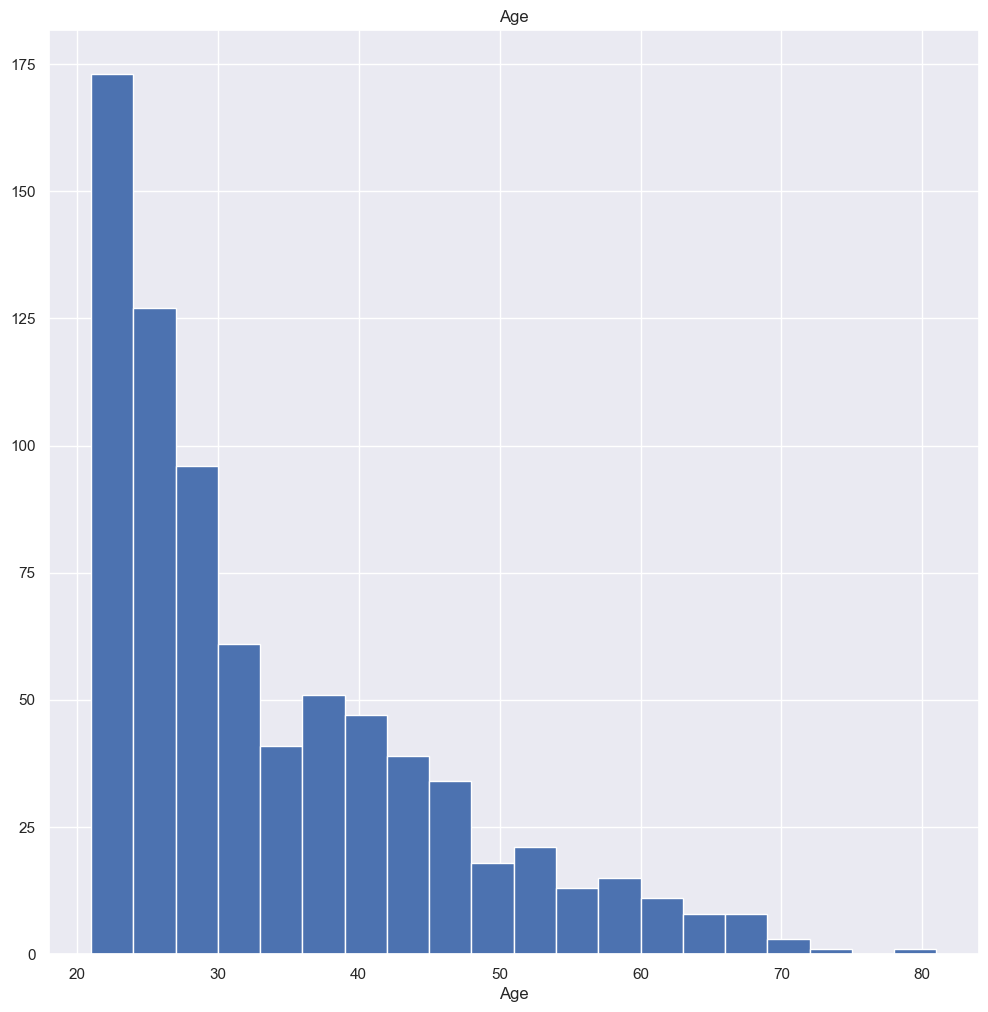

In [51]:
def num_summary(dataframe, numerical_col, plot=False):

    if plot and numerical_col != "Outcome":
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)
        

for col in numeric_columns:
    num_summary(df, col, plot=True)

         Pregnancies_mean
Outcome                  
0                3.298000
1                4.865672




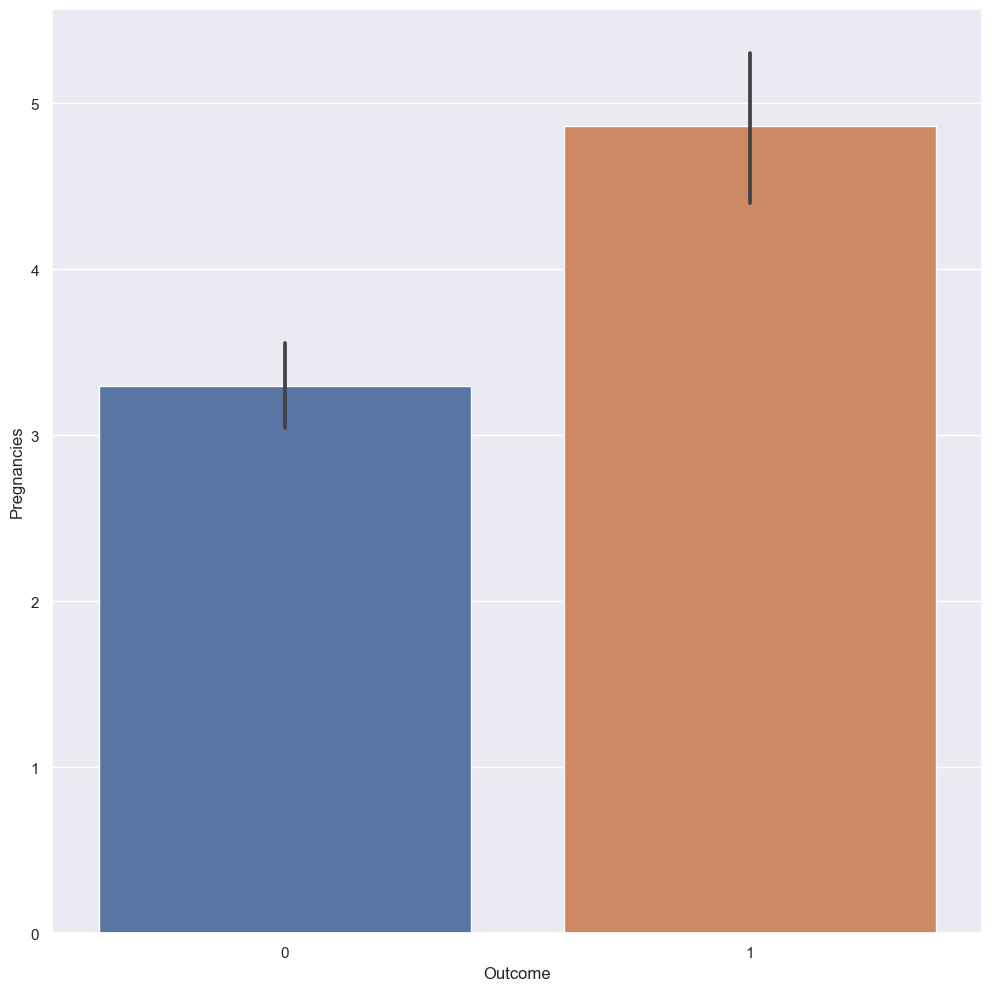

         Glucose_mean
Outcome              
0          109.980000
1          141.257463




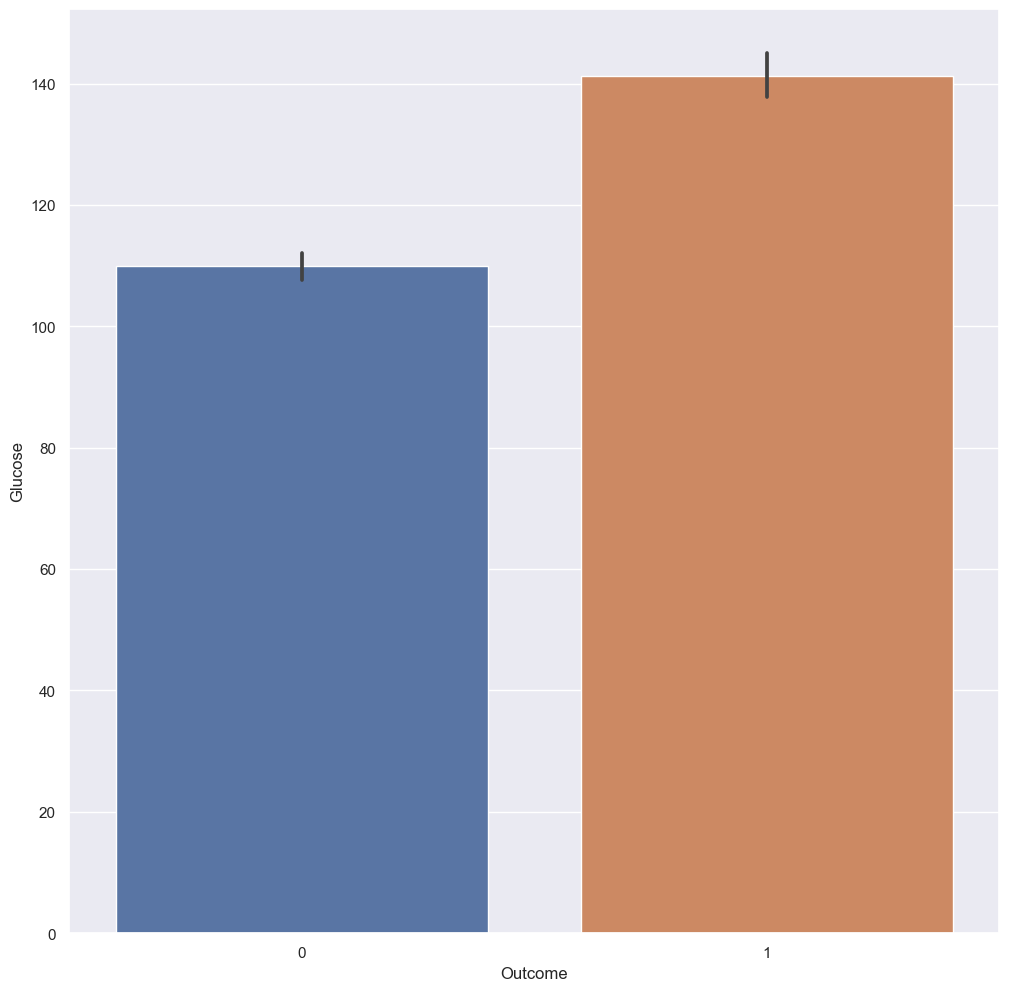

         BloodPressure_mean
Outcome                    
0                 68.184000
1                 70.824627




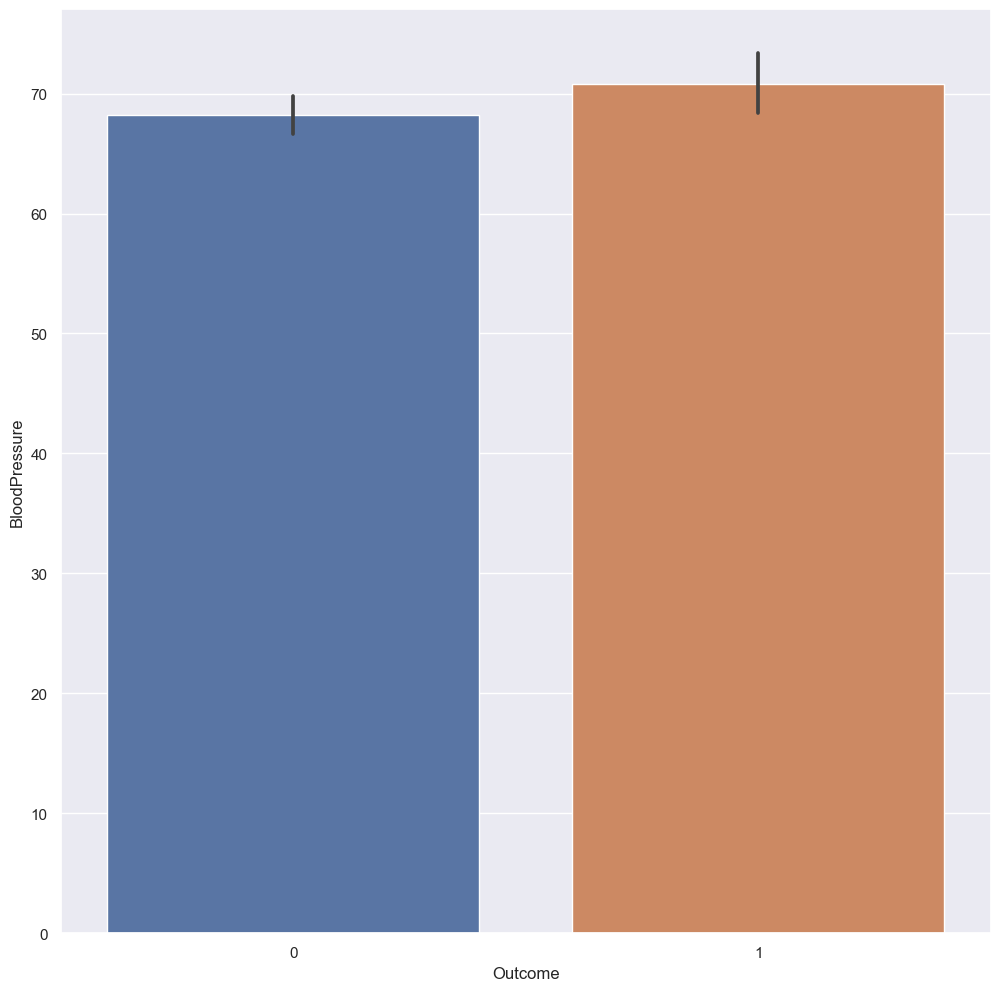

         SkinThickness_mean
Outcome                    
0                 19.664000
1                 22.164179




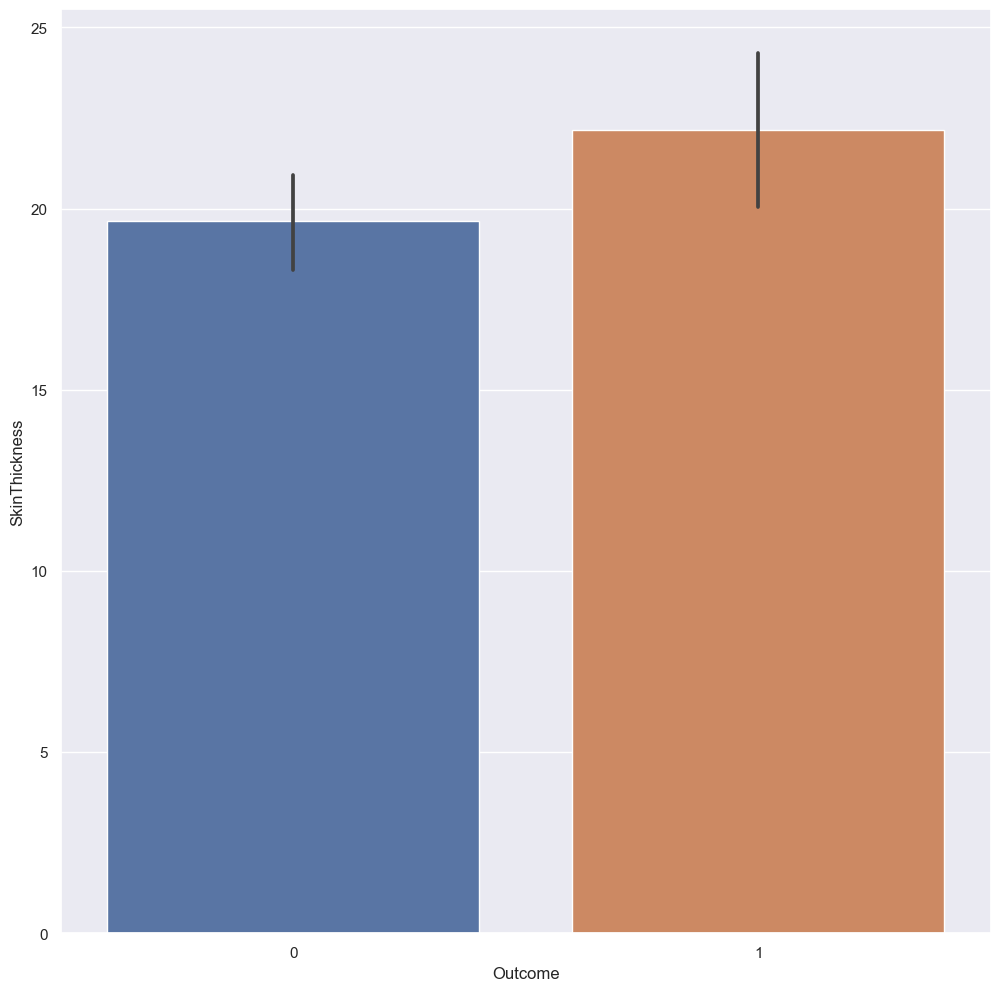

         Insulin_mean
Outcome              
0           68.792000
1          100.335821




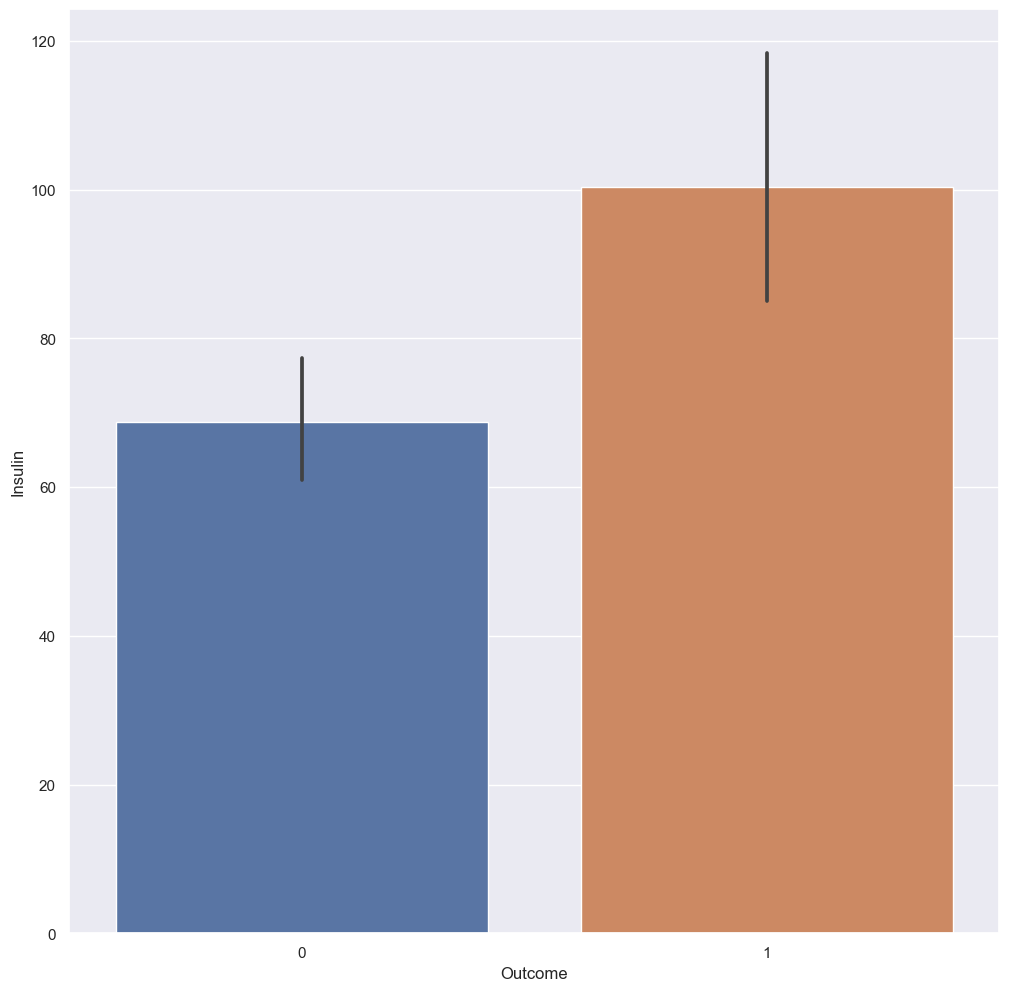

          BMI_mean
Outcome           
0        30.304200
1        35.142537




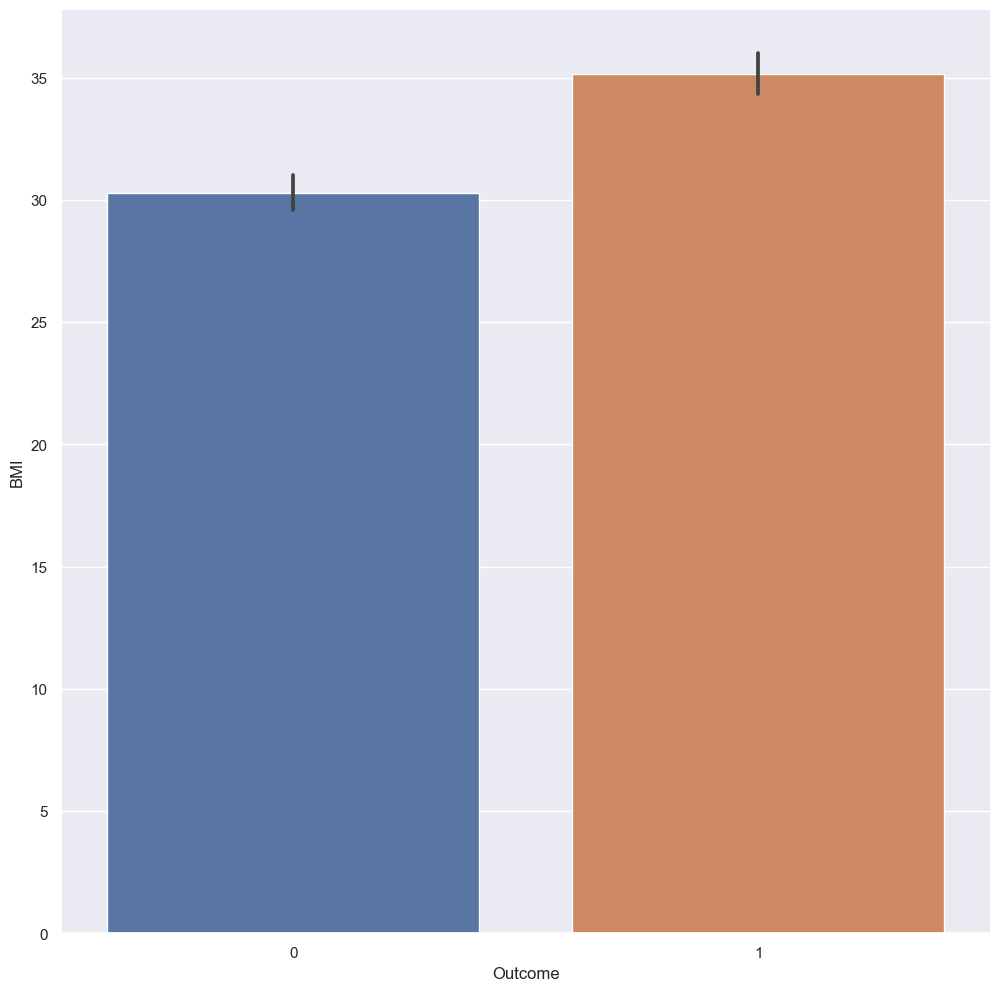

         DiabetesPedigreeFunction_mean
Outcome                               
0                             0.429734
1                             0.550500




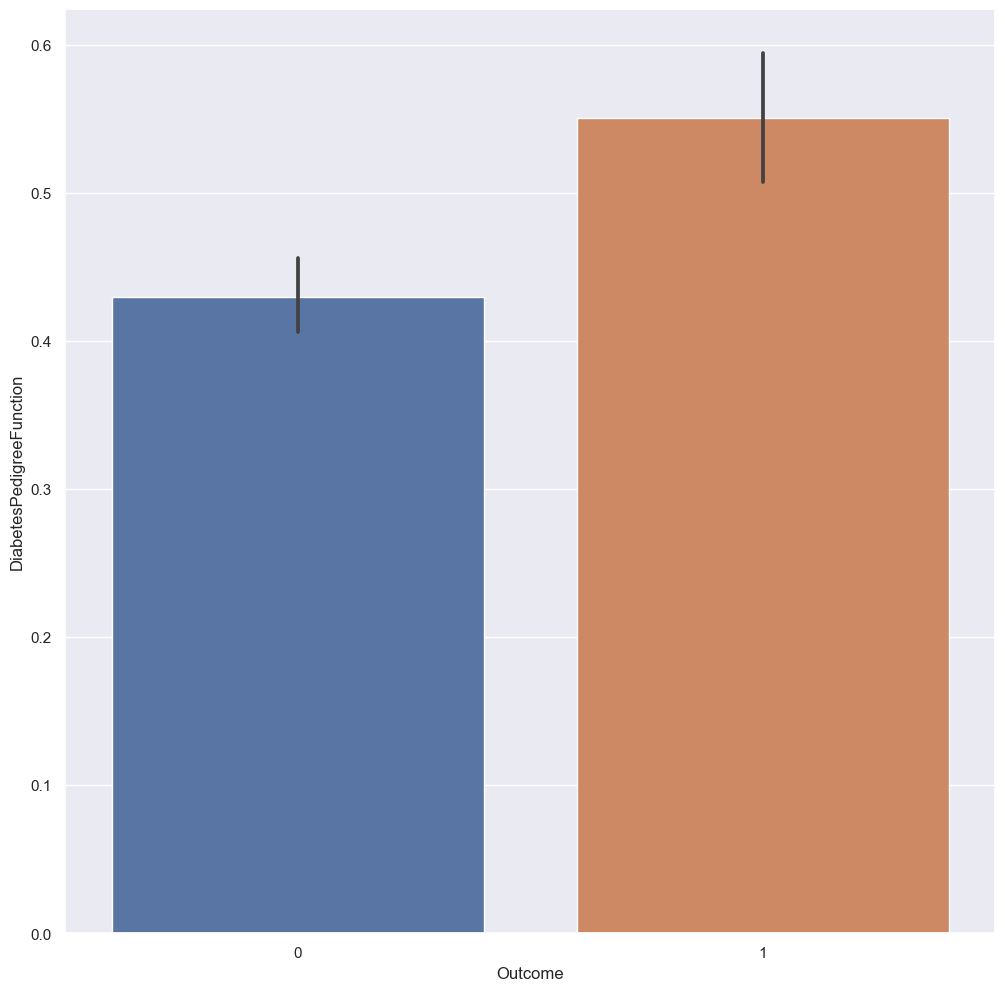

          Age_mean
Outcome           
0        31.190000
1        37.067164




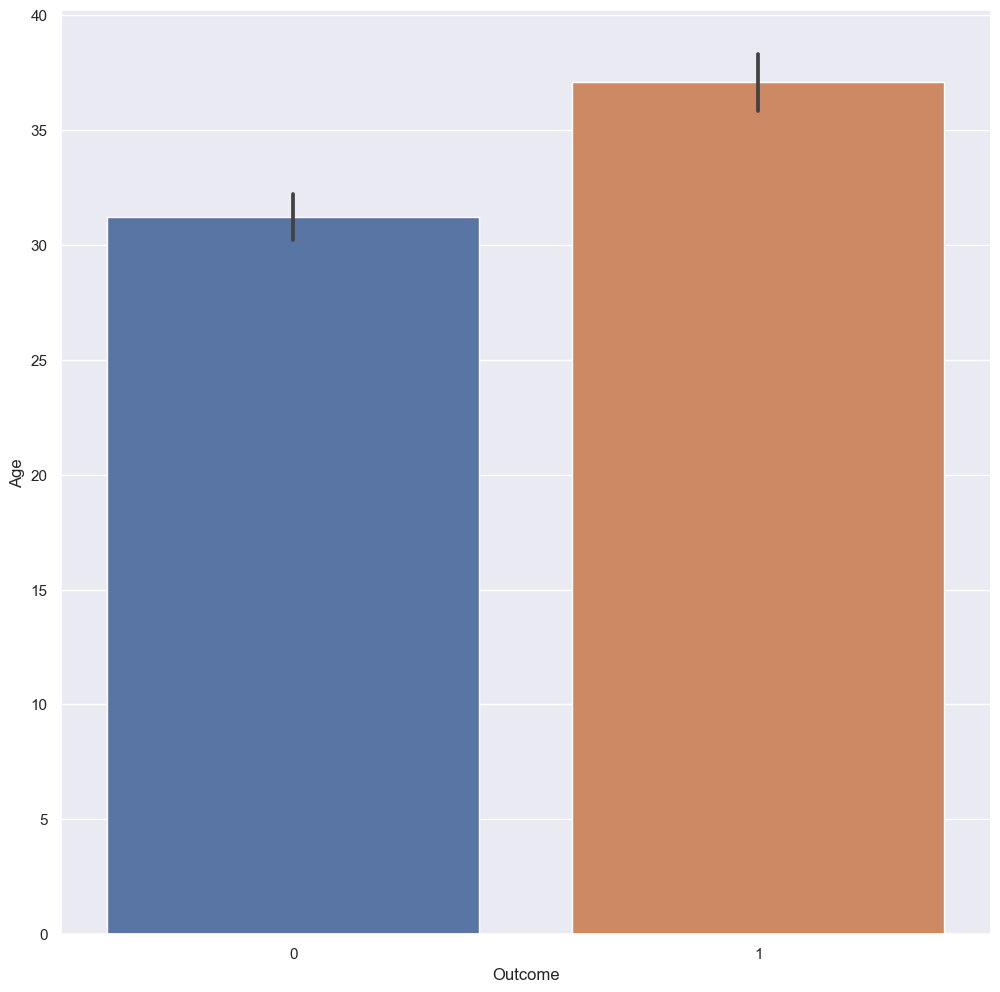

         Outcome_mean
Outcome              
0                 0.0
1                 1.0




In [52]:
def target_summary_with_num(dataframe, target, numerical_col, plot=False):
    print(pd.DataFrame({numerical_col+'_mean': dataframe.groupby(target)[numerical_col].mean()}), end='\n\n\n')
    if plot and numerical_col != "Outcome":
        sns.barplot(x=target, y=numerical_col, data=dataframe)
        plt.show(block=True)
        
for col in numeric_columns:
    target_summary_with_num(df, "Outcome", col, plot=True)

In [53]:
corr = df[numeric_columns].corr()
corr

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


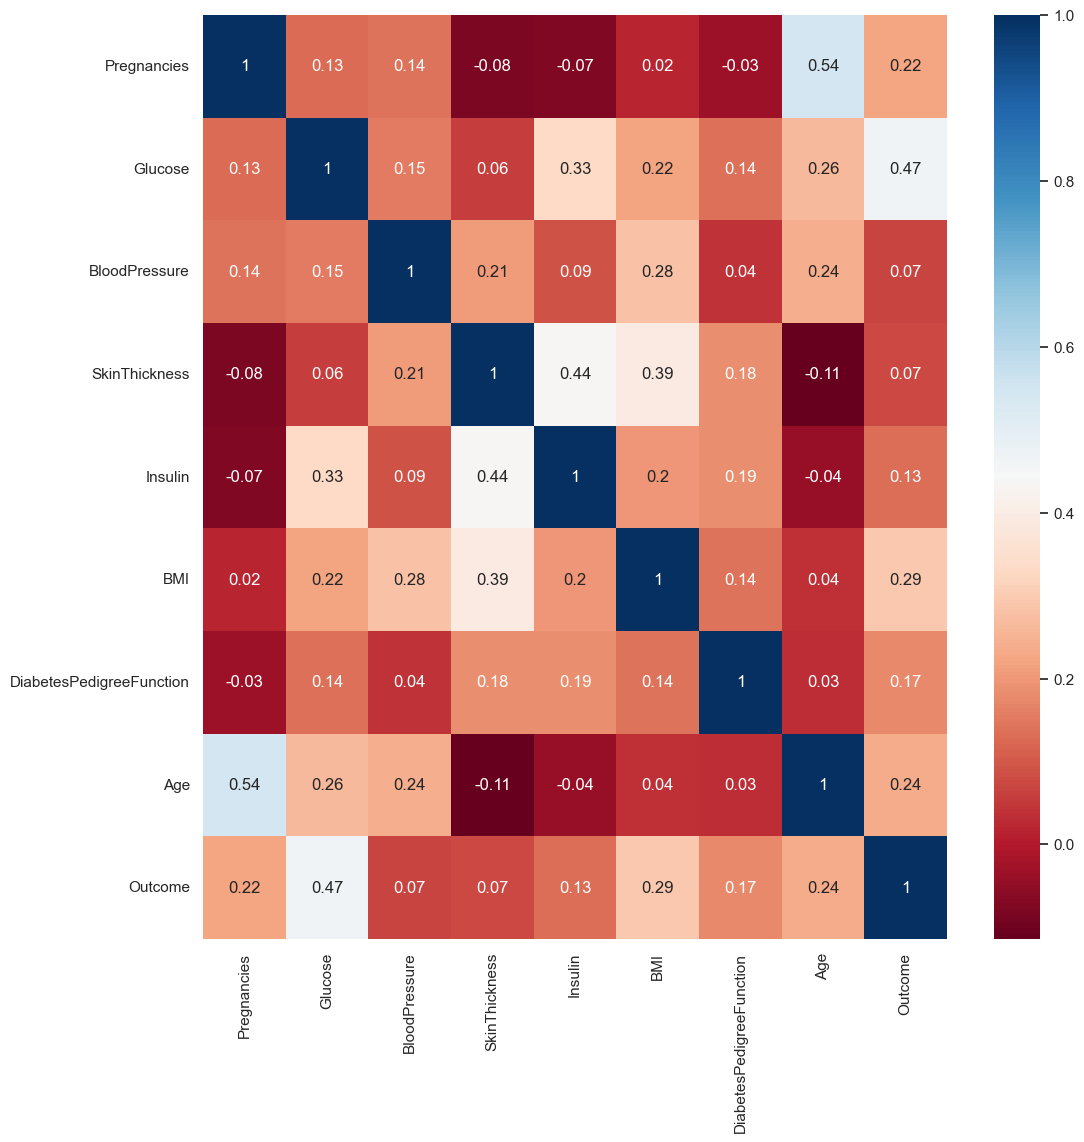

In [54]:
sns.set(rc={"figure.figsize": (12, 12)})
corr_values = corr.round(2)
sns.heatmap(corr, cmap="RdBu", annot=corr_values)
plt.show(block=True)

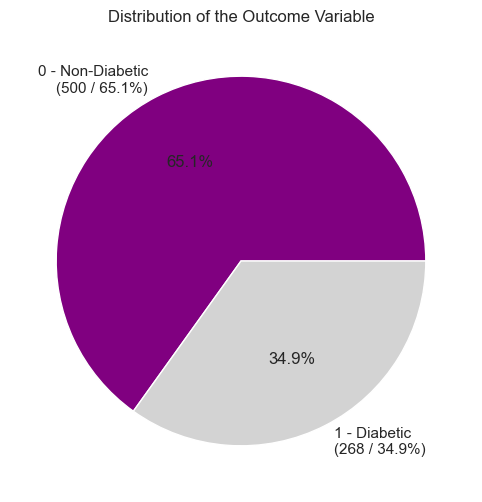

In [55]:
# Calculate the counts of each outcome
outcome_counts = df['Outcome'].value_counts()

# Calculate the total number of patients
total_patients = outcome_counts.sum()

# Calculate the percentages
percentages = outcome_counts / total_patients * 100

# Create labels with both quantity and percentage
labels = [f'0 - Non-Diabetic\n({outcome_counts[0]} / {percentages[0]:.1f}%)',
          f'1 - Diabetic\n({outcome_counts[1]} / {percentages[1]:.1f}%)']

# Plot the pie chart with labels and percentages
plt.figure(figsize=(8, 6))
plt.pie(outcome_counts, labels=labels, autopct='%1.1f%%', colors=['purple', 'lightgray'])
plt.title('Distribution of the Outcome Variable')
plt.show()

In [56]:
# Create combinations of binary categorical variables
feature_combinations = list(itertools.combinations(['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'], 2))

# Create a separate Bubble Chart for each binary categorical variable
for i, (feature1, feature2) in enumerate(feature_combinations):
    fig = px.scatter(df, x=feature1, y=feature2, color='Outcome', size='BMI',
                     title=f'{feature1} vs {feature2} Bubble Chart')

    fig.show(block=True)

In [57]:
y = df["Outcome"]

X = df.drop("Outcome", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [58]:
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)


y_pred = rf_model.predict(X_test)

print("RandomForestClassifier:")
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 4)}")
print(f"Recall: {round(recall_score(y_pred,y_test),4)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 4)}")
print(f"F1: {round(f1_score(y_pred,y_test), 4)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 4)}")

RandomForestClassifier:
Accuracy: 0.7706
Recall: 0.7059
Precision: 0.5926
F1: 0.6443
Auc: 0.7517


In [59]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

print("Logistic Regression:")
print(f"Accuracy: {round(accuracy_score(lr_pred, y_test), 4)}")
print(f"Recall: {round(recall_score(lr_pred, y_test), 4)}")
print(f"Precision: {round(precision_score(lr_pred, y_test), 4)}")
print(f"F1: {round(f1_score(lr_pred, y_test), 4)}")
print(f"AUC: {round(roc_auc_score(lr_pred, y_test), 4)}")

Logistic Regression:
Accuracy: 0.7879
Recall: 0.7667
Precision: 0.5679
F1: 0.6525
AUC: 0.781


C:\Users\pc\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [60]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)

print("K-Nearest Neighbors (KNN):")
print(f"Accuracy: {round(accuracy_score(knn_pred, y_test), 4)}")
print(f"Recall: {round(recall_score(knn_pred, y_test), 4)}")
print(f"Precision: {round(precision_score(knn_pred, y_test), 4)}")
print(f"F1: {round(f1_score(knn_pred, y_test), 4)}")
print(f"AUC: {round(roc_auc_score(knn_pred, y_test), 4)}")

K-Nearest Neighbors (KNN):
Accuracy: 0.7619
Recall: 0.6711
Precision: 0.6296
F1: 0.6497
AUC: 0.7388


In [61]:
svc_model = SVC()
svc_model.fit(X_train, y_train)
svc_pred = svc_model.predict(X_test)

print("Support Vector Classifier (SVC):")
print(f"Accuracy: {round(accuracy_score(svc_pred, y_test), 4)}")
print(f"Recall: {round(recall_score(svc_pred, y_test), 4)}")
print(f"Precision: {round(precision_score(svc_pred, y_test), 4)}")
print(f"F1: {round(f1_score(svc_pred, y_test), 4)}")
print(f"AUC: {round(roc_auc_score(svc_pred, y_test), 4)}")

Support Vector Classifier (SVC):
Accuracy: 0.7446
Recall: 0.6833
Precision: 0.5062
F1: 0.5816
AUC: 0.7247


In [62]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)

print("Decision Tree Classifier:")
print(f"Accuracy: {round(accuracy_score(dt_pred, y_test), 4)}")
print(f"Recall: {round(recall_score(dt_pred, y_test), 4)}")
print(f"Precision: {round(precision_score(dt_pred, y_test), 4)}")
print(f"F1: {round(f1_score(dt_pred, y_test), 4)}")
print(f"AUC: {round(roc_auc_score(dt_pred, y_test), 4)}")

Decision Tree Classifier:
Accuracy: 0.7056
Recall: 0.5823
Precision: 0.5679
F1: 0.575
AUC: 0.676


In [63]:
ada_model = AdaBoostClassifier()
ada_model.fit(X_train, y_train)
ada_pred = ada_model.predict(X_test)

print("AdaBoost Classifier:")
print(f"Accuracy: {round(accuracy_score(ada_pred, y_test), 4)}")
print(f"Recall: {round(recall_score(ada_pred, y_test), 4)}")
print(f"Precision: {round(precision_score(ada_pred, y_test), 4)}")
print(f"F1: {round(f1_score(ada_pred, y_test), 4)}")
print(f"AUC: {round(roc_auc_score(ada_pred, y_test), 4)}")

AdaBoost Classifier:
Accuracy: 0.7532
Recall: 0.6765
Precision: 0.5679
F1: 0.6174
AUC: 0.7309


In [64]:
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)

print("Gradient Boosting Classifier:")
print(f"Accuracy: {round(accuracy_score(gb_pred, y_test), 4)}")
print(f"Recall: {round(recall_score(gb_pred, y_test), 4)}")
print(f"Precision: {round(precision_score(gb_pred, y_test), 4)}")
print(f"F1: {round(f1_score(gb_pred, y_test), 4)}")
print(f"AUC: {round(roc_auc_score(gb_pred, y_test), 4)}")

Gradient Boosting Classifier:
Accuracy: 0.7749
Recall: 0.6933
Precision: 0.642
F1: 0.6667
AUC: 0.7537


In [65]:
# Dictionary containing the metric results
metrics = {
    "Model": ["Random Forest", "Logistic Regression", "KNN", "SVC", "Decision Tree", "AdaBoost", "Gradient Boosting"],
    "Accuracy": [0.7706, 0.7879, 0.7619, 0.7446, 0.7186, 0.7532, 0.7706],
    "Recall": [0.7059, 0.7667, 0.6711, 0.6833, 0.6053, 0.6765, 0.7],
    "Precision": [0.5926, 0.5679, 0.6296, 0.5062, 0.5679, 0.5679, 0.6049],
    "F1": [0.6443, 0.6525, 0.6497, 0.5816, 0.586, 0.6174, 0.649],
    "AUC": [0.7517, 0.781, 0.7388, 0.7247, 0.6897, 0.7309, 0.7506]
}

# Creating a DataFrame from the metrics dictionary
results_df = pd.DataFrame(metrics)

# Sorting the DataFrame by accuracy in descending order
results_df = results_df.sort_values(by="Accuracy", ascending=False)

# Creating the figure for the graph
fig = go.Figure()

# Colors for the metrics
colors = ["purple", "green", "blue", "orange", "red"]

# Adding traces for each metric in the specified order
for metric, color in zip(["Accuracy", "Recall", "Precision", "F1", "AUC"], colors):
    fig.add_trace(go.Bar(
        x=results_df["Model"],
        y=results_df[metric],
        marker_color=color,
        name=metric,
        text=results_df[metric],
        textposition='auto'
    ))

# Setting axis labels and title
fig.update_layout(
    xaxis_title="Model",
    yaxis_title="Metric Score",
    title="Comparison of Metrics for Different Models"
)

# Displaying the graph
fig.show(block=True)

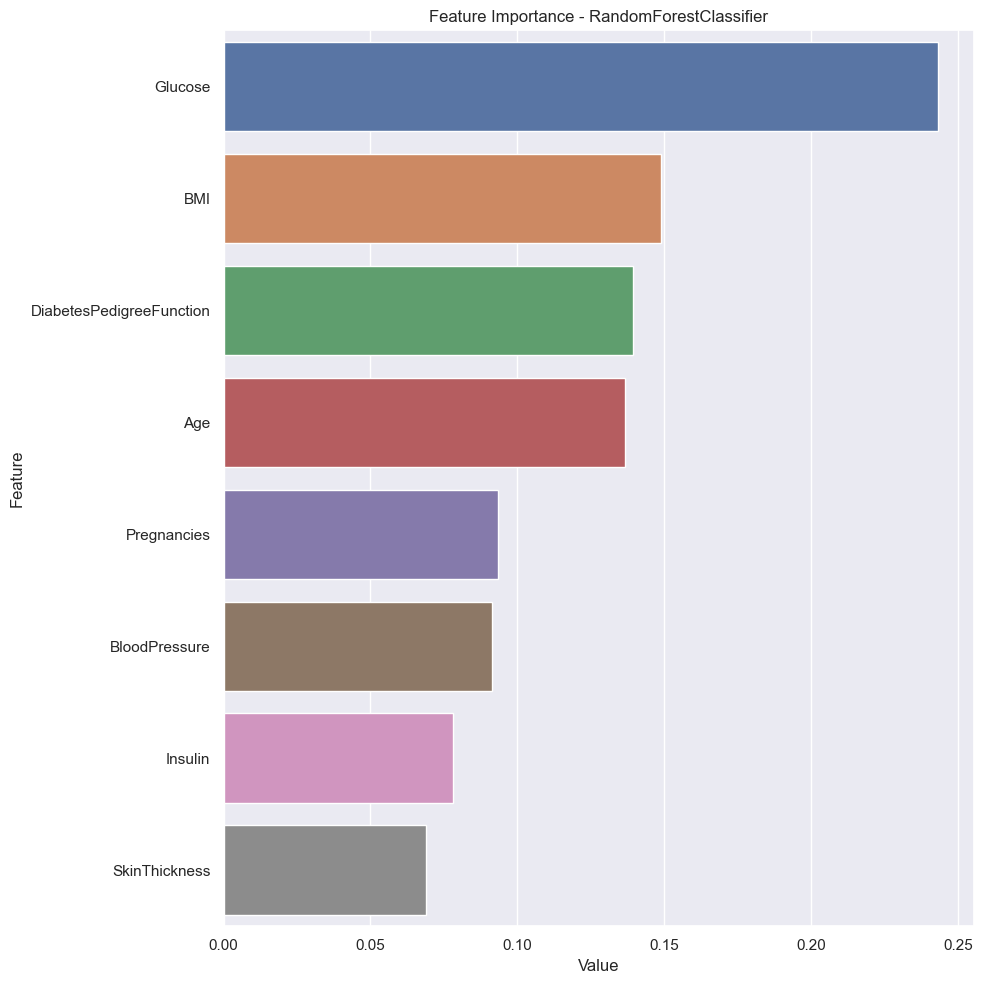

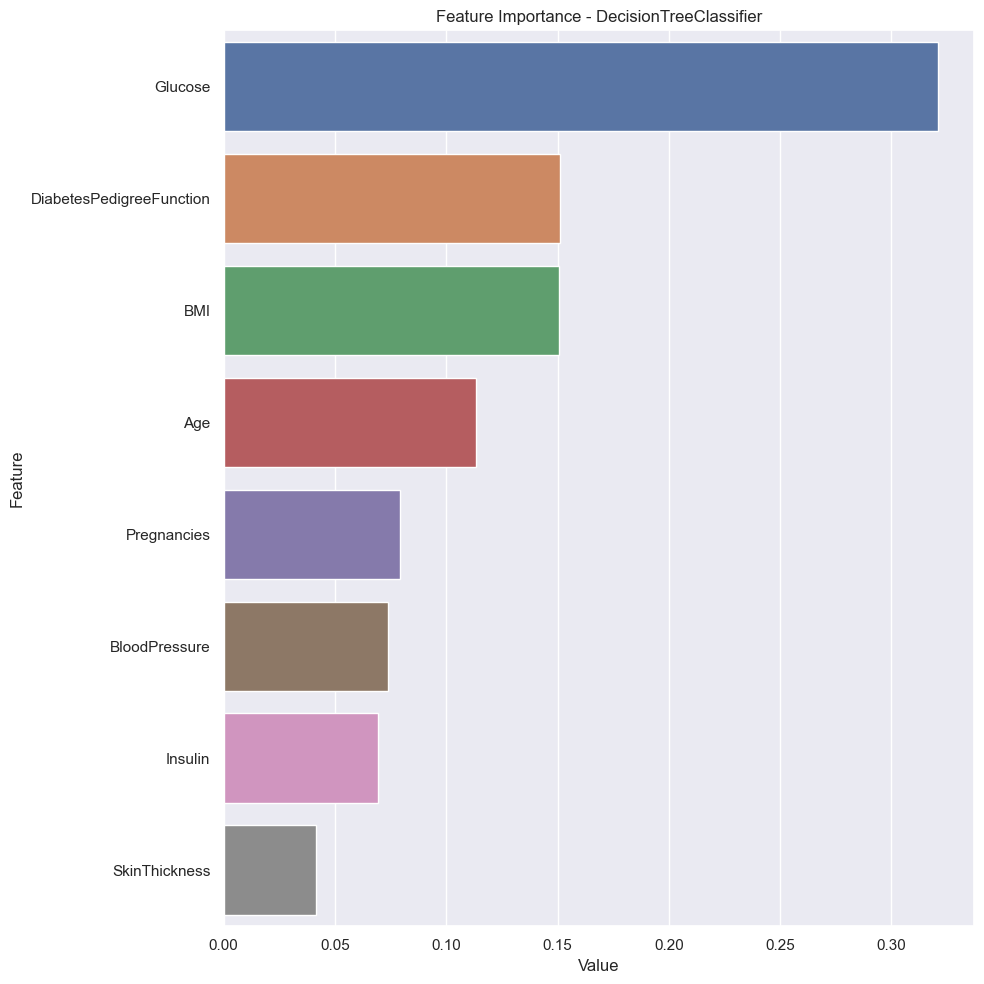

In [66]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title(f'Feature Importance - {model.__class__.__name__}')
    plt.tight_layout()
    plt.show(block=True)
    if save:
        plt.savefig('importances.png')
model_name = [rf_model, dt_model]
for i in model_name:
    plot_importance(i, X)